# The main implementation of thesis project

# Introduction

In this Python notesbook, we choose the following as baselines evaluate their performances:
- Supervised learning with simple network
- Supervised learning with ResNet50
- Supervised learning with VGG16
- Supervised learning with MobileNet

We then evaluate our self-supervised contrastive model, which uses InfoNCE, known as NT-Xent (Normalized Temperature-scaled Cross Entropy Loss) in SimCLR and used in other works like MoCo. 

The goal of our texture classification model is to train an embedding space constrained by contrastive loss, our model consists of two image augmentation transformers, base encoder, a projection head, and a pure linear regressor with cross-entropy loss as the customised accuracy metric.

# Importing libraries

In [42]:
import tensorflow as tf
from tensorflow import keras

# Setting local library path

Our modules lie in the directory *lib*, we add the path to the library searching path:

In [43]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configurations

In [44]:
image_size = (128, 128)
n_image_channels = 3

#input image shape
image_shape = (*image_size, n_image_channels) 

# projection head hidden dims
projhead_hidden_dims = (512, 200, ) 

# sample batch size
batch_size = 128  

# how many epochs
n_epochs = 20

#temperature = 0.1
temperature = 0.5




# Stronger augmentations for contrastive, weaker ones for supervised training

# self-supervised contrastive learning
strong_imgaug_params = {"image_shape": image_shape,
                             "min_area": 0.25, 
                             "brightness": 0.6, 
                             "jitter": 0.2}

# for linear regression based metric
weak_imgaug_params = { "image_shape": image_shape,
                            "min_area": 0.75, 
                            "brightness": 0.3, 
                            "jitter": 0.1}

# Preparing the dataset

## Loading datasets

In [45]:
train_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/train", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 2113
                )

Found 30800 files belonging to 154 classes.


In [46]:
test_dataset_ = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture/test", 
                image_size = image_size, 
                batch_size = batch_size,
                interpolation = "bilinear",
                color_mode = "rgb",
                shuffle = True,
                seed = 3371
                )

Found 7700 files belonging to 154 classes.


In [47]:
n_classes = len(train_dataset_.class_names)
print("n_classes = ", n_classes)

n_classes =  154


In [48]:
n_train_samples = len(train_dataset_) * batch_size
n_train_batches = len(train_dataset_)

print("n_train_samples = ", n_train_samples)
print("n_train_batches = ", n_train_batches)

n_train_samples =  30848
n_train_batches =  241


In [49]:
n_test_samples = len(test_dataset_) * batch_size
n_test_batches = len(test_dataset_)

print("n_test_samples = ", n_test_samples)
print("n_test_batches = ", n_test_batches)

n_test_samples =  7808
n_test_batches =  61


In [50]:
n_samples = n_train_samples + n_test_samples
n_batches = n_train_batches + n_test_batches

print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_samples =  38656
n_batches =  302


## Normalising datasets and setting data prefetching

In [51]:
train_dataset = train_dataset_.map(lambda x, y: (x / 255., y))
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

test_dataset = test_dataset_.map(lambda x, y: (x / 255., y))
test_dataset = test_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

## Verifying loaded dataset

In [52]:
x1 = next(iter(train_dataset))
x2 = x1[0]
x2.shape

TensorShape([128, 128, 128, 3])

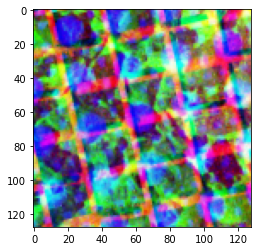

In [53]:
import matplotlib.pyplot as plt

img = next(iter(train_dataset))[0][0]

plt.imshow(img, vmin=0, vmax=1)
plt.show()

In [54]:
if "imgaug_model" in sys.modules:
    del sys.modules["imgaug_model"]

from imgaug_model import CustomisedTrainImageAugmenter

if "imgaug_viz" in sys.modules:
    del sys.modules["imgaug_viz"]
    
from imgaug_viz import plot_augmented_samples_train

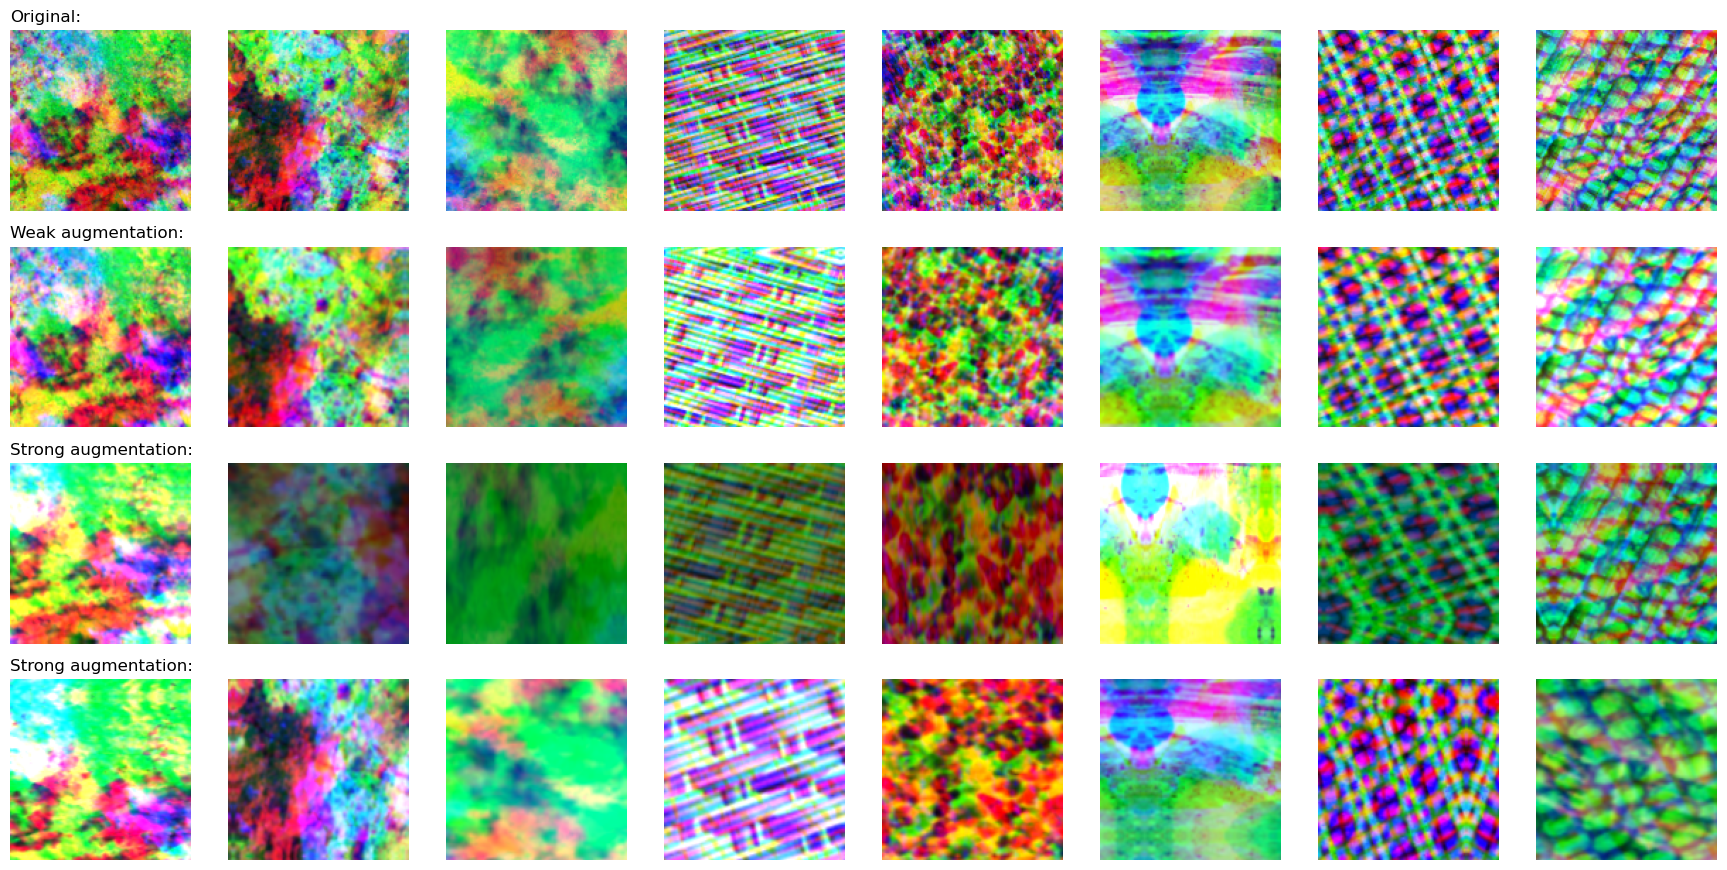

In [55]:
plot_augmented_samples_train(dataset = train_dataset, 
                             n_samples = 8, 
                             strong_imgaug_params = strong_imgaug_params, 
                             weak_imgaug_params = weak_imgaug_params, )

# Simple base encoder

In [90]:
def build_simple_encoder():
    return keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=image_shape, dtype = "float32"),
            
            keras.layers.Conv2D(32, kernel_size=3, strides=2, activation="relu"),
            keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Conv2D(128, kernel_size=3, strides=2, activation="relu"),            
            keras.layers.Conv2D(256, kernel_size=3, strides=2, activation="relu"), 
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.3),
            
            keras.layers.Flatten(),
            
            #keras.layers.Dense(512, activation="relu", name = "encoder_output"),
            #keras.layers.Dense(512, activation="relu", name = "encoder_output"),
        ],
        
        name = "encoder_simple",
    )

# Building supervised learning model with specified encoder

In [ ]:
def build_supervised_model( *,
                            image_shape = (128, 128, 3),      
                            learning_rate = 0.001,
                            n_classes,
                            encoder, 
                            imgaug_params,
                            name
                           ):
    
    newhead = keras.Sequential(
                [
                    keras.layers.Dense(512, activation="relu", name = "hidden_1"),
                    #keras.layers.Dense(512, activation="relu", name = "hidden_2"),
                    keras.layers.Dense(n_classes, name = "output"), 
                ], 
                name = "newhead"
            )
            
    
    model = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape = image_shape),
                CustomisedTrainImageAugmenter(**imgaug_params),
                encoder,
                newhead
            ],
            name = name,
        )

    model.compile(
            optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
            loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
            metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")],
        )
    
    print()
    newhead.summary()
    
    print()
    encoder.summary()
    
    print()
    model.summary()
    
    return model

# Baseline: Supervised learning with simple encoder

## Building model

In [101]:
baseline_encoder_simple = build_simple_encoder()
baseline_model_simple = build_supervised_model(image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_simple, 
                           imgaug_params = weak_imgaug_params,
                           name = "baseline_model_simple",
                           learning_rate = 0.001)


Model: "newhead"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 512)               6423040   
_________________________________________________________________
output (Dense)               (None, 154)               79002     
Total params: 6,502,042
Trainable params: 6,502,042
Non-trainable params: 0
_________________________________________________________________

Model: "encoder_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 63, 63, 32)        896       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 31, 31, 64)        256       
_______________________

## Training

In [ ]:
baseline_simple_history = baseline_model_simple.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
241/241 [==============================] - 144s 594ms/step - loss: 3.4686 - acc: 0.2124 - val_loss: 32.1654 - val_acc: 0.0101
Epoch 2/20
241/241 [==============================] - 143s 593ms/step - loss: 0.9747 - acc: 0.6925 - val_loss: 24.5363 - val_acc: 0.0130
Epoch 3/20
118/241 [=============>................] - ETA: 1:08 - loss: 0.5683 - acc: 0.8157

## Saving model and results

In [74]:
baseline_encoder_simple.save("models/baseline_encoder_simple.saved_model")
baseline_model_simple.save("models/baseline_model_simple.saved_model")

INFO:tensorflow:Assets written to: models/baseline_encoder_simple.saved_model/assets
INFO:tensorflow:Assets written to: models/baseline_model_simple.saved_model/assets


In [75]:
test_encoder = keras.models.load_model("models/baseline_encoder_simple.saved_model")
test_model = keras.models.load_model("models/baseline_model_simple.saved_model")

del test_encoder
del test_model

In [76]:
import pickle
import os

if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_simple_history.history, 
            open("results/baseline_simple_history.pickle", "wb" ))

In [77]:
history = pickle.load(open(b"results/baseline_simple_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

Maximal train accuracy: 97.02%
Maximal validation accuracy: 71.05%


## Plotting

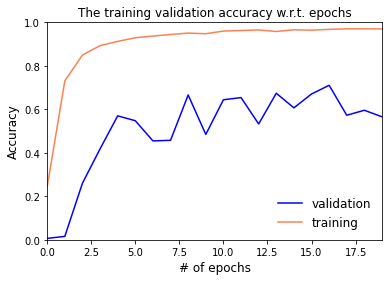

In [82]:
history = pickle.load(open(b"results/baseline_simple_history.pickle", "rb"))

val_accs = history["val_acc"]
train_accs = history["acc"]


plt.title("The training validation accuracy w.r.t. epochs")

plt.plot(val_accs, color = "blue", label = "validation")
plt.plot(train_accs, color = "coral", label = "training")

plt.xlabel("# of epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)

plt.xlim(0, len(val_accs) - 1)
plt.ylim(0, 1)

plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

plt.show()

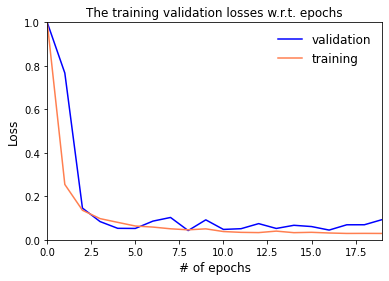

In [83]:
#val_loss = baseline_simple_history.history["val_loss"]
#train_loss = baseline_simple_history.history["loss"]
#
#plt.plot(val_loss, c = "blue")
#plt.plot(train_loss, c = "brown")
#
#plt.show()


history = pickle.load(open(b"results/baseline_simple_history.pickle", "rb"))

val_loss = history["val_loss"]
train_loss = history["loss"]

val_loss = np.array(val_loss) / max(val_loss)
train_loss = np.array(train_loss) / max(train_loss)

plt.title("The training validation losses w.r.t. epochs")

plt.plot(val_loss, color = "blue", label = "validation")
plt.plot(train_loss, color = "coral", label = "training")

plt.xlabel("# of epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)

plt.xlim(0, len(val_loss) - 1)
plt.ylim(0, 1)

plt.legend( #loc = 'upper center',
            fontsize = 12,
            ncol = 1, frameon = False)

plt.show()

# Baseline: Supervised learning with VGG16

## Building VGG16 encoder

In [84]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def build_vgg16_encoder():
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    model_orig = VGG16(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model_orig.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "vgg16_encoder")
    
    return model_new

## Building model

In [85]:
baseline_encoder_vgg16 = build_vgg16_encoder()
baseline_encoder_vgg16.trainable = False

baseline_model_vgg16 = build_supervised_model(image_shape = image_shape, 
                           n_classes = n_classes,
                           encoder = baseline_encoder_vgg16, 
                           imgaug_params = weak_imgaug_params,
                           name = "baseline_model_vgg16",
                           learning_rate = 0.001)


Model: "vgg16_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)    

## Training

In [86]:
baseline_vgg16_history = baseline_model_vgg16.fit(
                    train_dataset, 
                    epochs = n_epochs,
                    validation_data = test_dataset,
                    verbose = 1
                   )

Epoch 1/20
  3/241 [..............................] - ETA: 1:13:30 - loss: 5.2408 - acc: 0.0026  

KeyboardInterrupt: 

## Saving models and results

In [ ]:
baseline_encoder_vgg16.save("models/baseline_encoder_vgg16.saved_model")
baseline_model_vgg16.save("models/baseline_model_vgg16.saved_model")

In [ ]:
test_encoder = keras.models.load_model("models/baseline_encoder_vgg16.saved_model")
test_model = keras.models.load_model("models/baseline_model_vgg16.saved_model")

del test_encoder
del test_model

In [ ]:
if not os.path.exists("results"):
        os.makedirs("results")
    
    
pickle.dump(baseline_vgg16_history.history, 
            open("results/baseline_vgg16_history.pickle", "wb" ))

In [ ]:
history = pickle.load(open(b"results/baseline_vgg16_history.pickle", "rb"))

max_val_acc = max(history["val_acc"]) * 100
max_train_acc = max(history["acc"]) * 100

print(f"Maximal train accuracy: {max_train_acc:.2f}%")
print(f"Maximal validation accuracy: {max_val_acc:.2f}%")

## Plotting

# Baseline: Supervised learning with ResNet50

# Baseline: Supervised learning with MobileNet

# Contrastive learning with simple encoder

In [44]:

class ContrastiveModel(keras.Model):
    def __init__(self, 
                 *, 
                 temperature = 0.1,
                 encoder,
                 train_encoder = True,
                 #proj_dims = (500, 300), 
                 #imgaug,
                 #prob_imgaug,
                 ):
        
        super().__init__()

        self.temperature = temperature
        
        #self.contrastive_augmenter = build_augmenter(**contrastive_imgaug_params)
        #self.classification_augmenter = build_augmenter(**classification_imgaug_params)
        
        
        self.contrastive_augmenter = CustomisedTrainImageAugmenter(**strong_imgaug_params)
        self.classification_augmenter = CustomisedTrainImageAugmenter(**weak_imgaug_params)
        
        #self.encoder = build_simple_encoder()
        self.encoder = encoder
        self.train_encoder = train_encoder
        
        proj_input_shape = self.encoder.layers[-1].output.shape[1]
        print("proj_input_shape = ", proj_input_shape)
        
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.layers.InputLayer(input_shape=(proj_input_shape, )),
                layers.Dense(512, activation="relu"),
                layers.Dense(512), #pure linear
                #layers.BatchNormalization()
            ],
            name="projection_head",
        )
        
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [
                 layers.InputLayer(input_shape=(512,)), 
                 layers.Dense(n_classes), #pure linear
            ], 
                 name="linear_probe"
        )

        #self.encoder.summary()
        #self.projection_head.summary()
        #self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

        self.knn_accuracy = keras.metrics.BinaryAccuracy(name="k_acc", threshold=0.5)
        
    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker, #contrastive loss
            self.contrastive_accuracy, #contrastive accuracy
            self.probe_loss_tracker, #linear prober loss
            self.probe_accuracy, #linear prober accuracy
            #self.knn_accuracy #kNN accuracy
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        
        fake_labels = tf.range(batch_size)
                
        self.contrastive_accuracy.update_state(fake_labels, similarities)
        self.contrastive_accuracy.update_state(fake_labels, tf.transpose(similarities))

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, similarities, from_logits=True
        )
        
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            fake_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
     
        #unpacking the training images and labels (fake) in the batch
        images,labels = data
    
        
        """ The contrastive learning episode
        
        """
        
        # We randomly sample two transformation functions
        # and use them to augment the input batch (N images).
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)
        
        
        # We now have 2*N augmented images
        
        
        # tf.GradientTape is a basic facility in tensorflow, which implemented 
        # of recording operations for automatic differentiation..
        #
        # ref: https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # ref:
        
        # Create a GradientTape instance to record the forward process
        with tf.GradientTape() as tape:
            # Feeding augmented images (2*N) into the base encoder
            # to extract their features (2*N)
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            
            # Feeding the features (2*N) into the projection head, which is 
            # a MLP, the final layer is a pure linear layer.
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            
            # We now have 2*N projections from the projection head
            # and compute the contrastive loss (info-NCE)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
            
        # Computing the gradients w.r.t. every trainable variables by back-propogating the errors    
        # the *gradients* has the results with the form dL / dW
        
        if self.train_encoder:
            gradients = tape.gradient(
                contrastive_loss,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        
            # Optimising the weights by the computed gradients.
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.encoder.trainable_weights + self.projection_head.trainable_weights,
                )
            )
        else:
            gradients = tape.gradient(
                contrastive_loss,
                self.projection_head.trainable_weights,
            )
        
            # Optimising the weights by the computed gradients.
            self.contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    self.projection_head.trainable_weights,
                )
            )
            
        # Updating the loss history.
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        
        """ Updating the weights of the linear prediction model
        
        """
                        
        augmented_images_3 = self.classification_augmenter(images)
        
        # Forward
        with tf.GradientTape() as tape:
            
            features = self.encoder(augmented_images_3)
            
            features_2 = self.projection_head(features)
                      
            class_logits = self.linear_probe(features_2)
            
            probe_loss = self.probe_loss(labels, class_logits)
            
            
        # backwards, computing the gradients w.r.t. the linear prober
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        
        # updating the weights.
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        
        # updating history.
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)
        
        
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        
        images, labels = data

        augmented_images = self.classification_augmenter(images, training=False)
        
        features = self.encoder(augmented_images, training=False)
        features_2 = self.projection_head(features, training=False)
        
        class_logits = self.linear_probe(features_2, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        
        # knn accuracy
        
        return {m.name: m.result() for m in self.metrics[2:]}


In [45]:
contrastive_encoder_simple = build_simple_encoder()

contrastive_model_simple = ContrastiveModel(   temperature = 0.1,
                                               encoder = contrastive_encoder_simple,
                                               train_encoder = True)

contrastive_model_simple.compile(
            contrastive_optimizer = keras.optimizers.Adam(),
            probe_optimizer = keras.optimizers.Adam(),
        )

proj_input_shape =  512


In [28]:
n_epochs = 20
contrastive_simple_history = contrastive_model_simple.fit(
    train_dataset, 
    epochs=n_epochs, 
    validation_data=test_dataset,
    verbose = 1
)

Epoch 1/20
119/241 [=============>................] - ETA: 3:43 - c_loss: 4.8432 - c_acc: 0.0281 - p_loss: 4017.5449 - p_acc: 0.0070

KeyboardInterrupt: 

In [ ]:
val_p_acc = max(contrastive_simple_history.history["val_p_acc"]) * 100

p_acc = max(contrastive_simple_history.history["p_acc"]) * 100
c_acc = max(contrastive_simple_history.history["c_acc"]) * 100


print(f"Maximal validation linear prediction accuracy: {val_p_acc:.2f}%")
print(f"Maximal train linear prediction accuracy: {p_acc:.2f}%")
print(f"Maximal train contrastive accuracy: {c_acc:.2f}%")

# Contrastive learning with VGG16 without fine-tuning

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def build_vgg16_encoder():
    
    inputs = keras.Input(shape = image_shape, name = "inputs")
    
    model = VGG16(
            include_top = False,      # no pre-defined head
            input_tensor = inputs,    # input tensor
            input_shape = image_shape, # input shape
            weights = "imagenet",
            pooling = "max"           #max avg
            )   
    
    outputs = model.layers[-1].output
    #outputs = keras.layers.GlobalAveragePooling2D()(outputs)
    
    model_new = keras.Model(inputs = inputs, outputs = outputs, name = "VGG16-encoder")
    
    
    
    return model_new

In [46]:
vgg16_encoder = build_vgg16_encoder()

vgg16_encoder.trainable = False

contrastive_model_vgg16 = ContrastiveModel( temperature = 0.1,
                                            encoder = vgg16_encoder,
                                            train_encoder = False)

contrastive_model_vgg16.compile(
            contrastive_optimizer = keras.optimizers.Adam(),
            probe_optimizer = keras.optimizers.Adam(),
        )

proj_input_shape =  512


In [ ]:
contrastive_model_vgg16.save("models/contrastive_model_vgg16.saved_model")

In [47]:
n_epochs = 20

contrastive_vgg16_history = contrastive_model_vgg16.fit(
    train_dataset, 
    epochs=n_epochs, 
    validation_data=test_dataset,
    verbose = 1
)

Epoch 1/20
241/241 [==============================] - 16875s 70s/step - c_loss: 2.1372 - c_acc: 0.4443 - p_loss: 2.8152 - p_acc: 0.4480 - val_p_loss: 1.8300 - val_p_acc: 0.5575
Epoch 2/20
241/241 [==============================] - 4651s 19s/step - c_loss: 1.8696 - c_acc: 0.4977 - p_loss: 1.3445 - p_acc: 0.6918 - val_p_loss: 1.3675 - val_p_acc: 0.6151
Epoch 3/20
241/241 [==============================] - 4202s 17s/step - c_loss: 1.7791 - c_acc: 0.5157 - p_loss: 0.9750 - p_acc: 0.7439 - val_p_loss: 1.2537 - val_p_acc: 0.6395
Epoch 4/20
241/241 [==============================] - 4152s 17s/step - c_loss: 1.7093 - c_acc: 0.5309 - p_loss: 0.8170 - p_acc: 0.7641 - val_p_loss: 1.1467 - val_p_acc: 0.6592
Epoch 5/20
241/241 [==============================] - 4132s 17s/step - c_loss: 1.6632 - c_acc: 0.5422 - p_loss: 0.7237 - p_acc: 0.7797 - val_p_loss: 1.0992 - val_p_acc: 0.6670
Epoch 6/20
241/241 [==============================] - 4120s 17s/step - c_loss: 1.6453 - c_acc: 0.5438 - p_loss: 0.6876 

KeyboardInterrupt: 

# Contrastive learning with VGG16 with fine-tuning

# Visualising by projecting using UMAP

# Conclusions